In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup as soup
import json
import pandas as pd
import numpy as np

from highlight_text import ax_text,fig_text
import mplsoccer

In [2]:
#####UNDERSTAT
# shot location, shot result, the xG(expected goals) and Season
# HAALAND'S PLAYER ID IN UNDERSTAT IS 8260
url ='https://understat.com/player/8260'
html = requests.get(url)
parse_soup = soup(html.content,'lxml')
scripts = parse_soup.find_all('script')
strings = scripts[3].string
ind_start = strings.index("('")+2
ind_end = strings.index("')")
json_data = strings[ind_start:ind_end]
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)
x = []
y = []
xg = []
result = []
season = []
for i,_ in enumerate(data):
    for key in data[i]:
        if key=='X':
            x.append(data[i][key])
        if key=='Y':
            y.append(data[i][key])
        if key=='xG':
            xg.append(data[i][key])
        if key=='result':
            result.append(data[i][key])
        if key=='season':
            season.append(data[i][key])
columns = ['X','Y','xG','Result','Season']
df_understat = pd.DataFrame([x, y, xg, result, season], index=columns)
df_understat = df_understat.T
df_understat = df_understat.apply(pd.to_numeric,errors='ignore')
df_understat['X'] = df_understat['X'].apply(lambda x:x*100)
df_understat['Y'] = df_understat['Y'].apply(lambda x:x*100)

In [3]:
#####FBREF

def readfromhtml(filepath):
    df = pd.read_html(filepath)[0]
    column_lst = list(df.columns)
    for index in range(len(column_lst)):
        column_lst[index] = column_lst[index][1]
    df.columns = column_lst
    df.drop(df[df['Player'] == 'Player'].index, inplace=True)
    df = df.fillna('0')
    df.set_index('Rk', drop=True, inplace=True)
    try:
        df['Comp'] = df['Comp'].apply(lambda x: ' '.join(x.split()[1:]))
        df['Nation'] = df['Nation'].astype(str)
        df['Nation'] = df['Nation'].apply(lambda x: x.split()[-1])
    except:
        print('Error in uploading file:' + filepath)
    finally:
        df = df.apply(pd.to_numeric, errors='ignore')
        return df
    
df_fbref = readfromhtml('https://fbref.com/en/comps/Big5/shooting/players/Big-5-European-Leagues-Stats')

In [4]:
background = '#D6DBD9'
text_color = 'black'
mpl.rcParams['xtick.color']=text_color
mpl.rcParams['ytick.color']=text_color
mpl.rcParams['text.color']=text_color
mpl.rcParams['font.family']='Candara'
mpl.rcParams['legend.fontsize'] = 15

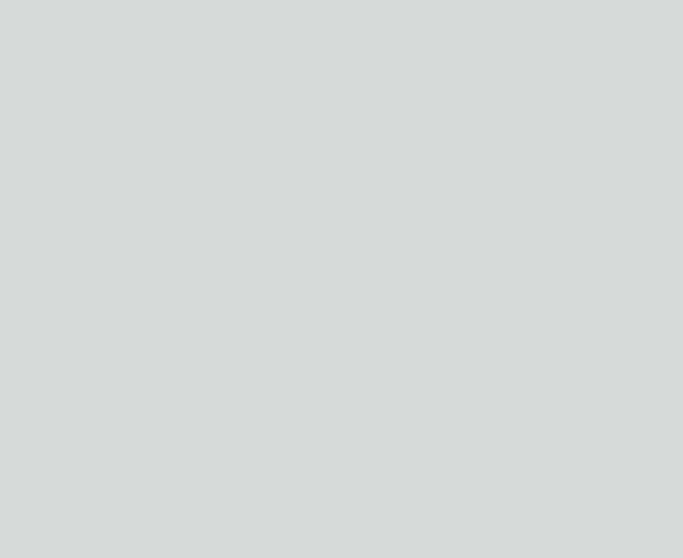

In [5]:
# SETTING UP THE AXES
fig, ax = plt.subplots(figsize=(12,10))
ax.axis('off')
fig.set_facecolor(background);

In [6]:
#SETTING UP THE MPL AXIS FOR THE FIRST SEASON
pitch = mplsoccer.VerticalPitch(half=True,pitch_type='opta', pitch_color='grass')
ax_opta1 = fig.add_axes((0.1, 0.06, 0.4, 0.4))
ax_opta1.patch.set_facecolor(background)
pitch.draw(ax=ax_opta1)

In [7]:
#NOW PLOTTING THE GOALS IN THE 2019-20 SEASON
df_fil = df_understat.loc[df_understat['Season']==2019]
pitch.scatter(df_fil[df_fil['Result']=='Goal']['X'],df_fil[df_fil['Result']=='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['Result']=='Goal']['xG'])*100, marker='o', alpha=0.9,
              edgecolor='black', facecolor='#6778d0', ax=ax_opta1, label='Goal');

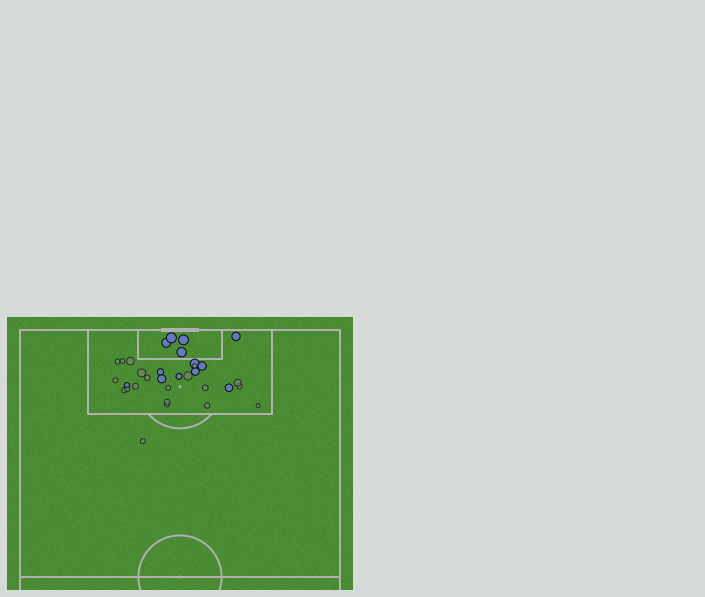

In [8]:
#PLOTTING OTHER SHOTS
pitch.scatter(df_fil[df_fil['Result']!='Goal']['X'],df_fil[df_fil['Result']!='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['Result']!='Goal']['xG'])*100, marker='o', alpha=0.6,
              edgecolor='black', facecolor='grey', ax=ax_opta1)
fig

In [18]:
# ADDING THE LEGEND
ax_opta1.legend(loc='lower right').get_texts()[0].set_color("black")

In [19]:
ax_opta1.text(25,61,'GOALS : '+str(len(df_fil[df_fil['Result']=='Goal'])), weight='bold', size=15)
ax_opta1.text(25,64,f"xG : {round(sum(df_fil['xG']),2)}", weight='bold', size=15)
ax_opta1.text(25,58,'SHOTS : '+str(len(df_fil)), weight='bold', size=15)
ax_opta1.text(85, 60, '2019-20', weight='bold', size=20)

Text(85, 60, '2019-20')

In [20]:
# NOW PLOTTING THE SCATTERPLOT
ax_scatter = fig.add_axes([0.52,0.57,0.4,0.35])
ax_scatter.patch.set_facecolor(background)

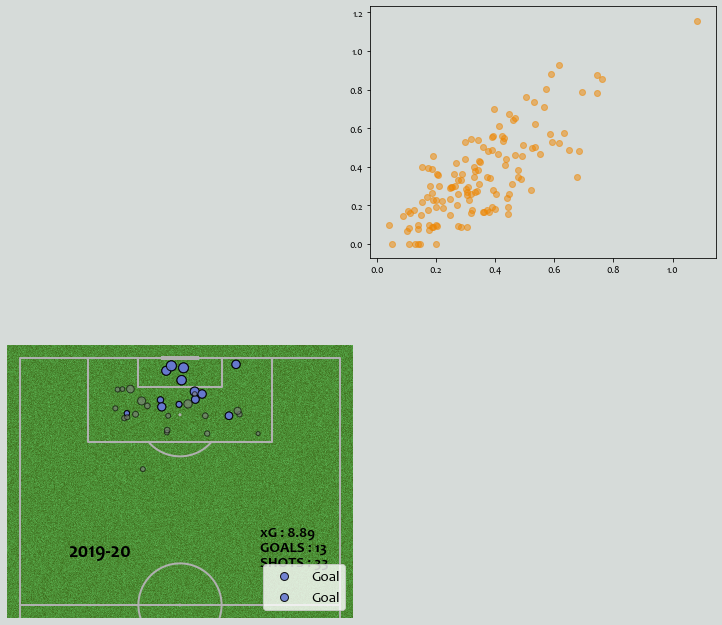

In [22]:
# SETTING UP THE X AND Y OF THE SCATTERPLOT
no_90s = 10
df_fil = df_fbref[df_fbref['90s']>=no_90s]
df_fil = df_fil[df_fil['Pos'].apply(lambda x: x in ['FW','MF,FW','FW,MF'])]
x,y = (df_fil['xG']/df_fil['90s']).to_list(), (df_fil['Gls']/df_fil['90s']).to_list()
ax_scatter.scatter(x,y,alpha=0.3,c='#EF8804')
fig

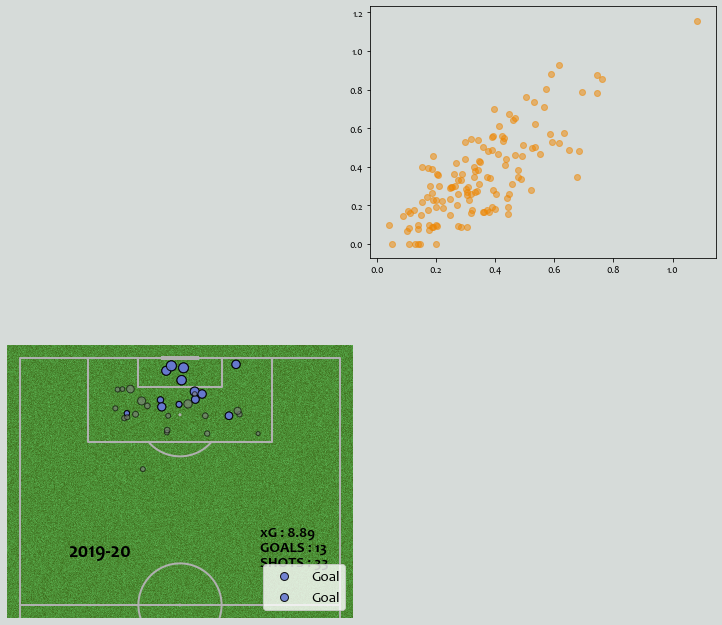

In [24]:
# NOW FILTERING ERLING HAALAND'S DATA
df_player = df_fil[df_fil['Player']=='Erling Haaland']
ax_scatter.scatter(df_player['xG']/df_player['90s'], df_player['Gls']/df_player['90s'], c='blue')

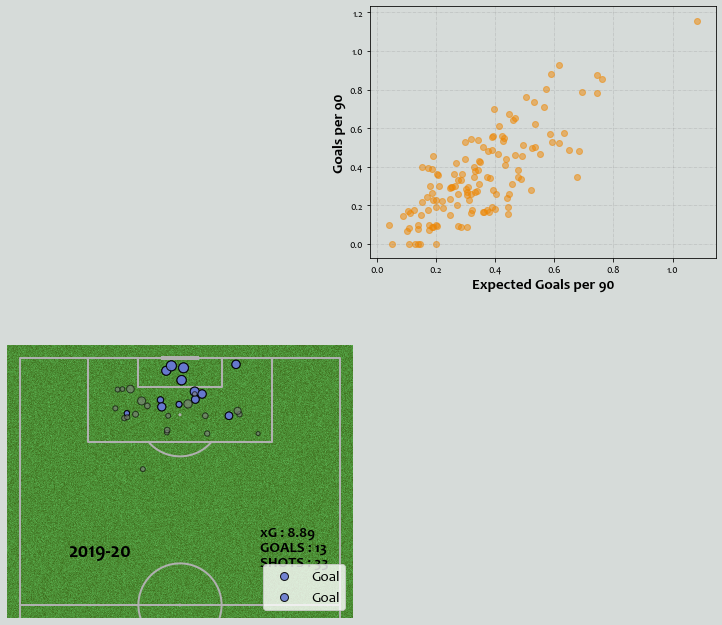

In [25]:
# ADDING FINISHING TOUCHES TO THE SCATTERPLOT
ax_scatter.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.4)
ax_scatter.set_xlabel('Expected Goals per 90', fontdict = {'fontsize':15, 'weight' : 'bold', 'color':text_color})
ax_scatter.set_ylabel('Goals per 90', fontdict = dict(fontsize = 15, weight = 'bold',color=text_color))
fig

In [ ]:
#ADDING HAALAND'S IMAGE
#ax_player = fig.add_axes([0,0.43,0.25,0.45])
#ax_player.axis('off')
#im = plt.imread('haaland.png')
#ax_player.imshow(im)

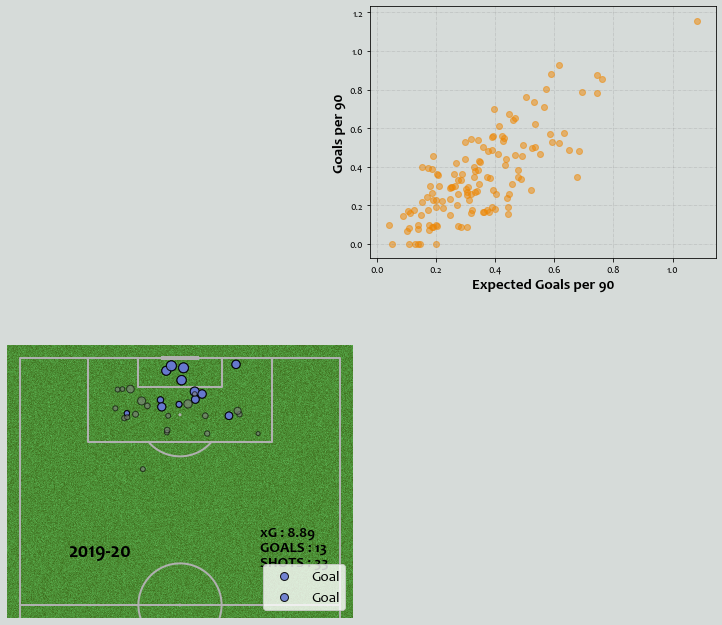

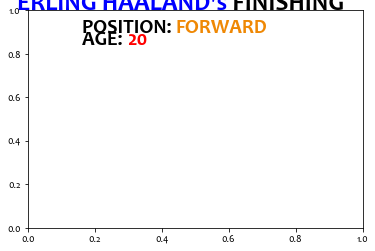

In [27]:
# ADDING TITLES AND INFO
fig_text(0.1,0.94,"<ERLING HAALAND's> FINISHING",weight='heavy', size=25, highlight_textprops=[{'color':'blue'}])
fig_text(0.25,0.85,'POSITION: <FORWARD>',weight='bold', size=20, highlight_textprops=[{'color':'#EF8804'}])
fig_text(0.25,0.81,'AGE: <20>',weight='bold', size=20, highlight_textprops=[{'color':'red'}])

In [ ]:
# ADDING CLUB LOGO
#ax_team = fig.add_axes([0.27,0.55,0.15,0.15])
#ax_team.axis('off')
#im = plt.imread('bvb.png')
#ax_team.imshow(im)

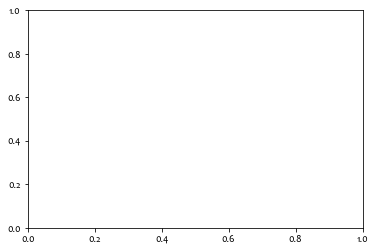

In [28]:
# ADDING A FOOTER
fig_text(0.05,0.03,'Made by Shreyas Khatri/@khatri_shreyas. Data from Fbref.com and Understat.com. Comparison with <forwards>'+
        ' with more than '+str(no_90s)+' 90s('+str(no_90s*90)+' minutes).',
        size=12, highlight_textprops=[{'color':'#EF8804'}], weight = 'bold')


In [17]:
%matplotlib inline

